In [1]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import itertools
from torch.nn import init
import time

In [2]:
# dataloader arguments
batch_size = 128
data_path='./Emnist'

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.EMNIST(data_path, split = 'byclass', train=True, download=True, transform=transform)
mnist_test = datasets.EMNIST(data_path, split = 'byclass', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

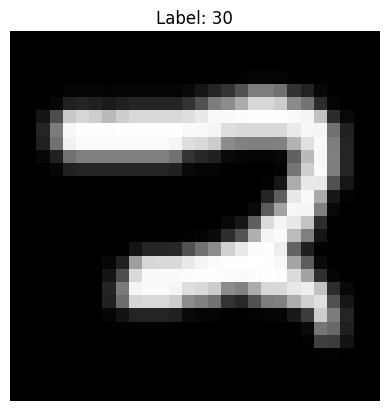

In [5]:
data, target = next(iter(train_loader))
i=10
plt.imshow(data[i][0], cmap='gray')
plt.title(f'Label: {target[i].item()}')
plt.axis('off')
plt.show()

In [4]:
test_acc_list = []
for i in range(21):
    beta = 0.8+0.01*i
    print(beta)
    # Network Architecture
    num_inputs = 28*28
    num_hidden = 2000
    num_outputs = 62
    
    # Temporal Dynamics
    num_steps = 25
    #beta = 0.95
    
    # Define Network
    class my_Net(nn.Module):
        def __init__(self):
            super().__init__()
    
            # Initialize layers
            self.fc1 = nn.Linear(num_inputs, num_hidden)
            self.lif1 = snn.Leaky(beta=beta)
            self.fc2 = nn.Linear(num_hidden, num_hidden)
            self.lif2 = snn.Leaky(beta=beta)
    
        def forward(self, x):
    
            # Initialize hidden states at t=0
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()
    
            # Record the final layer
            spk2_rec = []
            mem2_rec = []
    
            for step in range(num_steps):
                cur1 = self.fc1(x[step])
                spk1, mem1 = self.lif1(cur1, mem1)
                cur2 = self.fc2(spk1)
                spk2, mem2 = self.lif2(cur2, mem2)
                spk2_rec.append(spk2)
                mem2_rec.append(mem2)
    
            return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
    def generate_spike(x):
        data_input = x.view(128,-1)
        spk_input = []
        for batch in range(128):
            spk_input_batch = spikegen.rate(data_input[batch], num_steps = 25)
            spk_input.append(spk_input_batch)
        return torch.stack(spk_input, dim = 1)


    # Load the network onto CUDA if available
    net = my_Net().to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    
    #generate train data
    num_epochs = 1
    train_result = []
    train_tgt = []
    for epoch in range(num_epochs):
        iter_counter = 0
        train_batch = iter(train_loader)
        # Train set
        with torch.no_grad():
            net.eval()
            for train_data, train_targets in train_batch:
                train_data = train_data.to(device)
                train_targets = train_targets.to(device)
                # Test set forward pass
                train_spk, train_mem = net(generate_spike(train_data))
                
                train_tgt.append(train_targets)
                train_result.append(train_spk)
    
                iter_counter += 1
                if iter_counter == 400:
                    break
    
    train_input = torch.stack(train_result, dim=0).sum(dim = 1)
    train_t = torch.stack(train_tgt, dim=0)
    
    train_net = torch.nn.Linear(num_hidden, num_outputs)
    optimizer1 = torch.optim.Adam(train_net.parameters(), lr=5e-4, betas=(0.9, 0.999))
    my_train_loss_hist = []
    for batch in range(400):
        # print(batch)
        train_net_out = train_net(train_input[batch])
        train_loss = torch.zeros((1), dtype=dtype, device=device)
        train_loss = loss(train_net_out, train_t[batch])
        # Gradient calculation + weight update
        optimizer1.zero_grad()
        train_loss.backward()
        optimizer1.step()
        my_train_loss_hist.append(train_loss.item())
    
    # test my net
    my_test_result = []
    my_test_tgt = []
    for epoch in range(num_epochs):
        iter_counter_test = 0
        test_batch = iter(test_loader)
        # Test set
        with torch.no_grad():
            net.eval()
            for my_test_data, my_test_targets in test_batch:
                my_test_data = my_test_data.to(device)
                my_test_targets = my_test_targets.to(device)
                # Test set forward pass
                my_test_spk, my_test_mem = net(generate_spike(my_test_data))
                
                my_test_tgt.append(my_test_targets)
                my_test_result.append(my_test_spk)
    
                iter_counter_test += 1
                if iter_counter_test == 50:
                    break
    
    max_value, max_index = train_net(torch.stack(my_test_result, dim=0).sum(dim = 1)).max(dim=2)
    testacc = sum(max_index.reshape(-1) == torch.stack(my_test_tgt, dim=0).reshape(-1))/6400
    test_acc_list.append(testacc)

0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.8500000000000001
0.8600000000000001
0.8700000000000001
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.9700000000000001
0.98
0.99
1.0


In [7]:
test_acc_list

[tensor(0.1892),
 tensor(0.2827),
 tensor(0.2905),
 tensor(0.3816),
 tensor(0.4120),
 tensor(0.4866),
 tensor(0.5484),
 tensor(0.5788),
 tensor(0.5938),
 tensor(0.6228),
 tensor(0.6419),
 tensor(0.6603),
 tensor(0.6784),
 tensor(0.6845),
 tensor(0.6927),
 tensor(0.6969),
 tensor(0.6978),
 tensor(0.6994),
 tensor(0.7111),
 tensor(0.7109),
 tensor(0.7025)]

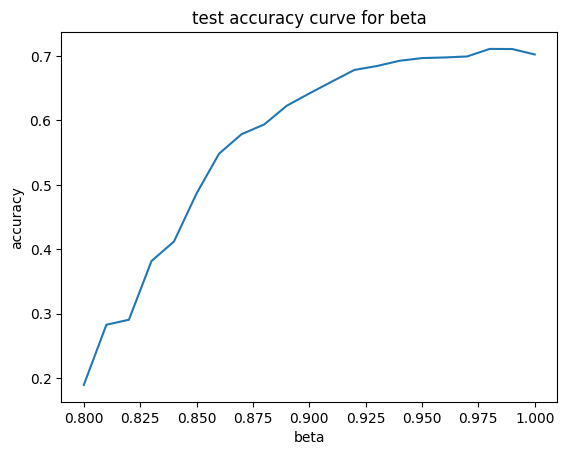

In [9]:
x_label = 0.8+0.01*torch.arange(0,21)
y_mean_list = []
plt.plot(x_label, test_acc_list)
plt.title("test accuracy curve for beta")
plt.xlabel("beta")
plt.ylabel("accuracy")
plt.show()

In [11]:
# 将列表转换为 NumPy 数组
arr = np.array(test_acc_list)

# 保存数组到 .npy 文件
np.save('test_acc_Emnist_beta.npy', arr)

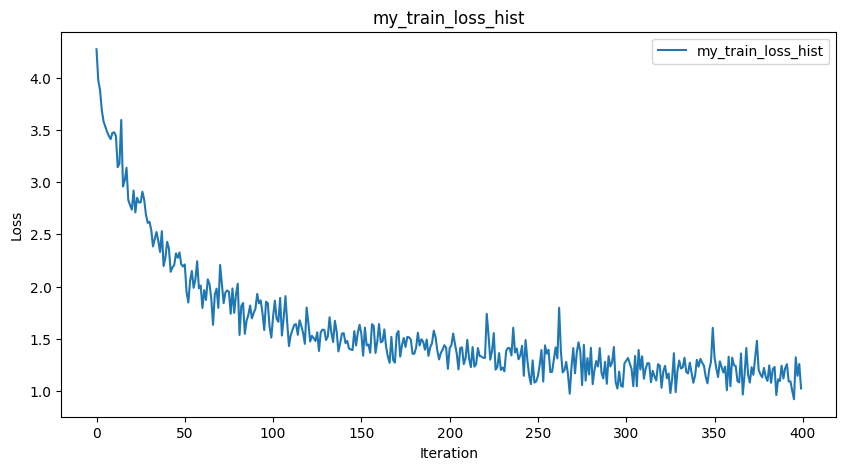

In [23]:
# Plot Loss
# fig = plt.figure(facecolor="w", figsize=(10, 5))
# plt.plot(my_train_loss_hist)
# plt.title("my_train_loss_hist")
# plt.legend(["my_train_loss_hist"])
# plt.xlabel("Iteration")
# plt.ylabel("Loss")
# plt.show()